In [1]:
%matplotlib inline
import glob
from fractions import Fraction
import itertools
import multiprocessing
import numpy as np
from numba import njit, prange
import cv2
import matplotlib.pyplot as plt

In [2]:
root_dir = './Test_Images/Building_F8_ISO125_1o8_to_1o2048/'

In [3]:
image_list = glob.glob(root_dir+'*.JPG') + glob.glob(root_dir+'*.jpg')

In [4]:
def path2exposure(paths):
    ret = []
    for path in paths:
        exposure = list(map(int, ''.join(path.split('/')[-1].split('.')[:-1]).split(':')))
        if len(exposure) == 1:
            exposure.append(1)
        assert len(exposure) == 2, 'Name should be in fraction!'
        ret.append((Fraction(exposure[0],exposure[1]), path))
    ret.sort(key=lambda x: x[0])
    return ret

In [5]:
def exposure2imgs(exposure_paths):
    imgs = {}
    for exposure, path in exposure_paths:
        imgs[exposure] = cv2.imread(path, cv2.IMREAD_COLOR)[...,:3][...,::-1].astype(np.uint8) # BGR->RGB
    return imgs

In [6]:
def makeMTB(rgb, thresh=2):
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    median = np.median(gray)
    MTB = (gray>median).astype(np.bool)
    ignore_mask = (gray<median+thresh).astype(np.bool) & (gray>median-thresh).astype(np.bool)
    return (MTB*255).astype(np.uint8), (ignore_mask*255).astype(np.uint8)

In [7]:
def next_power2(n):
    return int(2**np.ceil(np.log2(n)))

In [8]:
def translate_img(img, dx, dy):
    img_r = np.roll(np.roll(img, dy, axis=0), dx, axis=1)
    ignore_mask = np.zeros_like(img)
    if dy<0:
        img_r[dy:] = 0
        ignore_mask[dy:] = 255
    elif dy>0:
        img_r[:dy] = 0
        ignore_mask[:dy] = 255
    if dx<0:
        img_r[:,dx:] = 0
        ignore_mask[:,dx:] = 255
    elif dx>0:
        img_r[:,:dx] = 0
        ignore_mask[:,:dx] = 255
    return img_r, ignore_mask

In [9]:
def match_local(mtb_r, mtb, ignore, last_trans_x, last_trans_y):
    best = 0
    best_d = (0, 0) # order: x, y
    for dy, dx in itertools.product([0,1,-1],[0,1,-1]):
        shift_x = last_trans_x+dx
        shift_y = last_trans_y+dy
        mtb_patch = np.roll(np.roll(mtb, shift_y, axis=0), shift_x, axis=1)
        ignore_patch = np.roll(np.roll(ignore, shift_y, axis=0), shift_x, axis=1)
        if shift_y<0:
            ignore_patch[shift_y:] = 255 # missing values due to translation
        elif shift_y>0:
            ignore_patch[:shift_y] = 255
        if shift_x<0:
            ignore_patch[:,shift_x:] = 255
        elif shift_x>0:
            ignore_patch[:,:shift_x] = 255
        matched_n = np.sum((mtb_r==mtb_patch).astype(np.bool) & (~ignore_patch).astype(np.bool))
        if matched_n>best:
            best = matched_n
            best_d = (dx,dy)
    return (last_trans_x + best_d[0], last_trans_y + best_d[1])

def resize_worker(mtb, ignore, W, H):
    mtb_resize = np.where(cv2.resize(mtb, (W,H), interpolation=cv2.INTER_AREA)<128,0,255)
    ignore_resize = np.where(cv2.resize(ignore, (W,H), interpolation=cv2.INTER_AREA)<128,0,255)
    return (mtb_resize, ignore_resize)

In [10]:
def pyramidSearch(MTBs_w_mask, max_trans=70, reference_frame=None):
    # Input: MTBs_w_mask (list of tuples): [(mtb, ignore), (mtb, ignore), ...]
    #        reference_frame (integer): which picture we want to align to
    if reference_frame is None:
        reference_frame = len(MTBs_w_mask)//2
    n_levels = int(np.ceil(np.log2(max_trans)))
    H_ori, W_ori = MTBs_w_mask[0][0].shape[:2]
    
    ### Pad the original image ###
    # Pad Width if it is not power of 2
    pad_w = next_power2(W_ori) - W_ori if (W_ori & (W_ori-1) != 0) else 0
    pad_h = next_power2(H_ori) - H_ori if (H_ori & (H_ori-1) != 0) else 0
    
    if pad_w>0 or pad_h>0:
        padded = []
        for (mtb, ignore) in MTBs_w_mask:
            pad_mtb = np.pad(mtb, ((0,pad_h),(0,pad_w)), mode='constant', constant_values=0)
            pad_ignore = np.pad(ignore, ((0,pad_h),(0,pad_w)), mode='constant', constant_values=255)
            padded.append((pad_mtb, pad_ignore))
    else:
        padded = MTBs_w_mask
    
    H_pad, W_pad = padded[0][0].shape[:2]
    trans_x = [0]*len(padded)
    trans_y = [0]*len(padded)
    for l in reversed(range(0, n_levels)):
        step = int(2**l)
        H = H_pad//step
        W = W_pad//step
        if step == 1:
            resized = padded
        else:
            results = []
            pool = multiprocessing.Pool()
            for mtb, ignore in padded:
                results.append(pool.apply_async(resize_worker, args=(mtb, ignore, W, H)))
            resized = [x.get() for x in results]
            pool.close()
            pool.join()
        mtb_r, ignore_r = resized[reference_frame]
        pool = multiprocessing.Pool()
        results = []
        for n, (mtb, ignore) in enumerate(resized):
            if n == reference_frame: # self
                continue
            results.append(pool.apply_async(match_local, args=(mtb_r, mtb, ignore, trans_x[n]*2, trans_y[n]*2)))
        task_i = 0
        for n in range(len(resized)):
            if n == reference_frame: # self
                continue
            (best_x, best_y) = results[task_i].get()
            trans_x[n] = best_x
            trans_y[n] = best_y
            task_i += 1
        pool.close()
        pool.join()
    return trans_x, trans_y, reference_frame

In [11]:
exposure_paths = path2exposure(image_list)

In [12]:
imgs = exposure2imgs(exposure_paths)

In [13]:
MTBs_w_mask = [tuple(makeMTB(imgs[exposure])) for exposure in sorted(list(imgs))]

In [14]:
trans_x, trans_y, reference_frame = pyramidSearch(MTBs_w_mask)

In [15]:
trans_x, trans_y

([-5, -5, 7, 7, 0, 7, 3, -11, 1], [11, 9, 8, 8, 0, 8, 1, 2, 1])

In [16]:
def make_hat_function():
    window_function = np.linspace(0, 2, 256)
    window_function[-128:] = 2.0 - window_function[-128:]
    return window_function

def solve_response_curve(I, B, l, w):
    N = 256
    n, p = I.shape #exposure, pixel
    A = np.zeros((n*p+1+N-2, N+p),dtype=np.float32) # rows: (n_exposure*n_pixel+reg_p+reg_curve), cols: (n_color+n_pixels)
    b = np.zeros((n*p+1+N-2, 1),dtype=np.float32)
    k = 0
    for exp_i in range(n):
        for pix_i in range(p):
            wij = w[I[exp_i,pix_i]]
            A[k,I[exp_i,pix_i]] = wij
            A[k,N+pix_i] = -wij
            b[k,0] = wij*B[exp_i]
            k += 1
    A[k,128] = 1
    k += 1
    C = np.array([l,-2*l,l],dtype=np.float32)
    for i in range(N-2):
        A[k,i:i+3] = C * w[i+1]
        k += 1
    x = np.linalg.lstsq(A,b,rcond=None)[0]
    g = x[:N]
    lnE = x[N:]
    return g, lnE

In [17]:
img_list = np.stack([ imgs[x] for x in sorted(list(imgs)) ])

In [18]:
img_list.shape

(9, 3456, 4608, 3)

In [19]:
accept_map = None
for n in range(len(img_list)):
    img_shifted, ignore = translate_img(img_list[n], trans_x[n], trans_y[n])
    img_list[n] = img_shifted
    accept = ~ignore.astype(np.bool)[:,:,0]
    accept_map = accept if accept_map is None else (accept & accept_map)

In [20]:
pix_idx = np.nonzero(accept_map)
rand_idx = np.random.choice(len(pix_idx[0]), 1000, replace=False)
subset = img_list[:,pix_idx[0][rand_idx],pix_idx[1][rand_idx],:]
lnT = np.arange(len(imgs))
print(subset.shape)

(9, 1000, 3)


In [21]:
window_function = make_hat_function()

In [22]:
g_R, lnE_R = solve_response_curve(subset[:,:,0], lnT, 0.01, window_function)
g_G, lnE_G = solve_response_curve(subset[:,:,1], lnT, 0.01, window_function)
g_B, lnE_B = solve_response_curve(subset[:,:,2], lnT, 0.01, window_function)

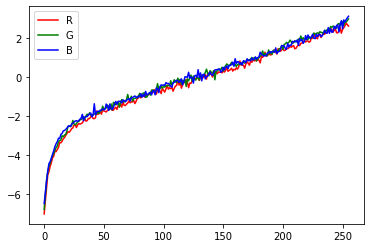

In [23]:
plt.plot(g_R, label='R', color='red')
plt.plot(g_G, label='G', color='green')
plt.plot(g_B, label='B', color='blue')
plt.legend(loc='upper left')
plt.show()

In [24]:
@njit(parallel=True, nogil=True)
def recover_radiance_map(I, g, window, lnT):
    # I: (n_exposure, h, w, 3)
    # g: (256, 3)
    # w: (256)
    # lnT: (n_exposure,)
    n_exposure, h, w = I.shape[:3]
    radiance_map = np.zeros((h, w, 3), dtype=np.float32)
    for i in prange(h):
        for j in prange(w):
            for c in prange(3):
                wij = window[I[:,i,j,c]]
                gij = g[I[:,i,j,c],c]
                radiance_map[i,j,c] = np.sum( wij * (gij - lnT) ) / (np.sum(wij)+1e-8)
    return radiance_map

In [25]:
def tone_mapping(img, alpha=1.0, compress_color=0.4):
    rgb = 2**img
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    rgb = rgb / gray[...,np.newaxis] # normalize
    blur = cv2.bilateralFilter(gray, 7, 31, 31)
    min_v = blur.min()
    max_v = blur.max()
    diff = gray-blur
    Lw_mean = 2**np.mean(np.log2(blur+1e-8))
    Lm = alpha * blur / max(Lw_mean, 1e-8)
    #Ld = Lm * (1 + Lm / (blur*blur)) / (1 + Lm) # bugs
    Ld = Lm / (1 + Lm)
    #print(Ld.max(), hsv[...,0].max(), hsv[...,1].max())
    fix_v = np.clip((Ld + diff)[...,np.newaxis], 1e-8, 1-1e-8)
    ldr_rgb = np.clip((rgb**compress_color) * fix_v, 1e-8, 1-1e-8)
    return ldr_rgb

In [26]:
radiance_map = recover_radiance_map(img_list, np.concatenate((g_R,g_G,g_B),axis=-1), window_function, lnT)

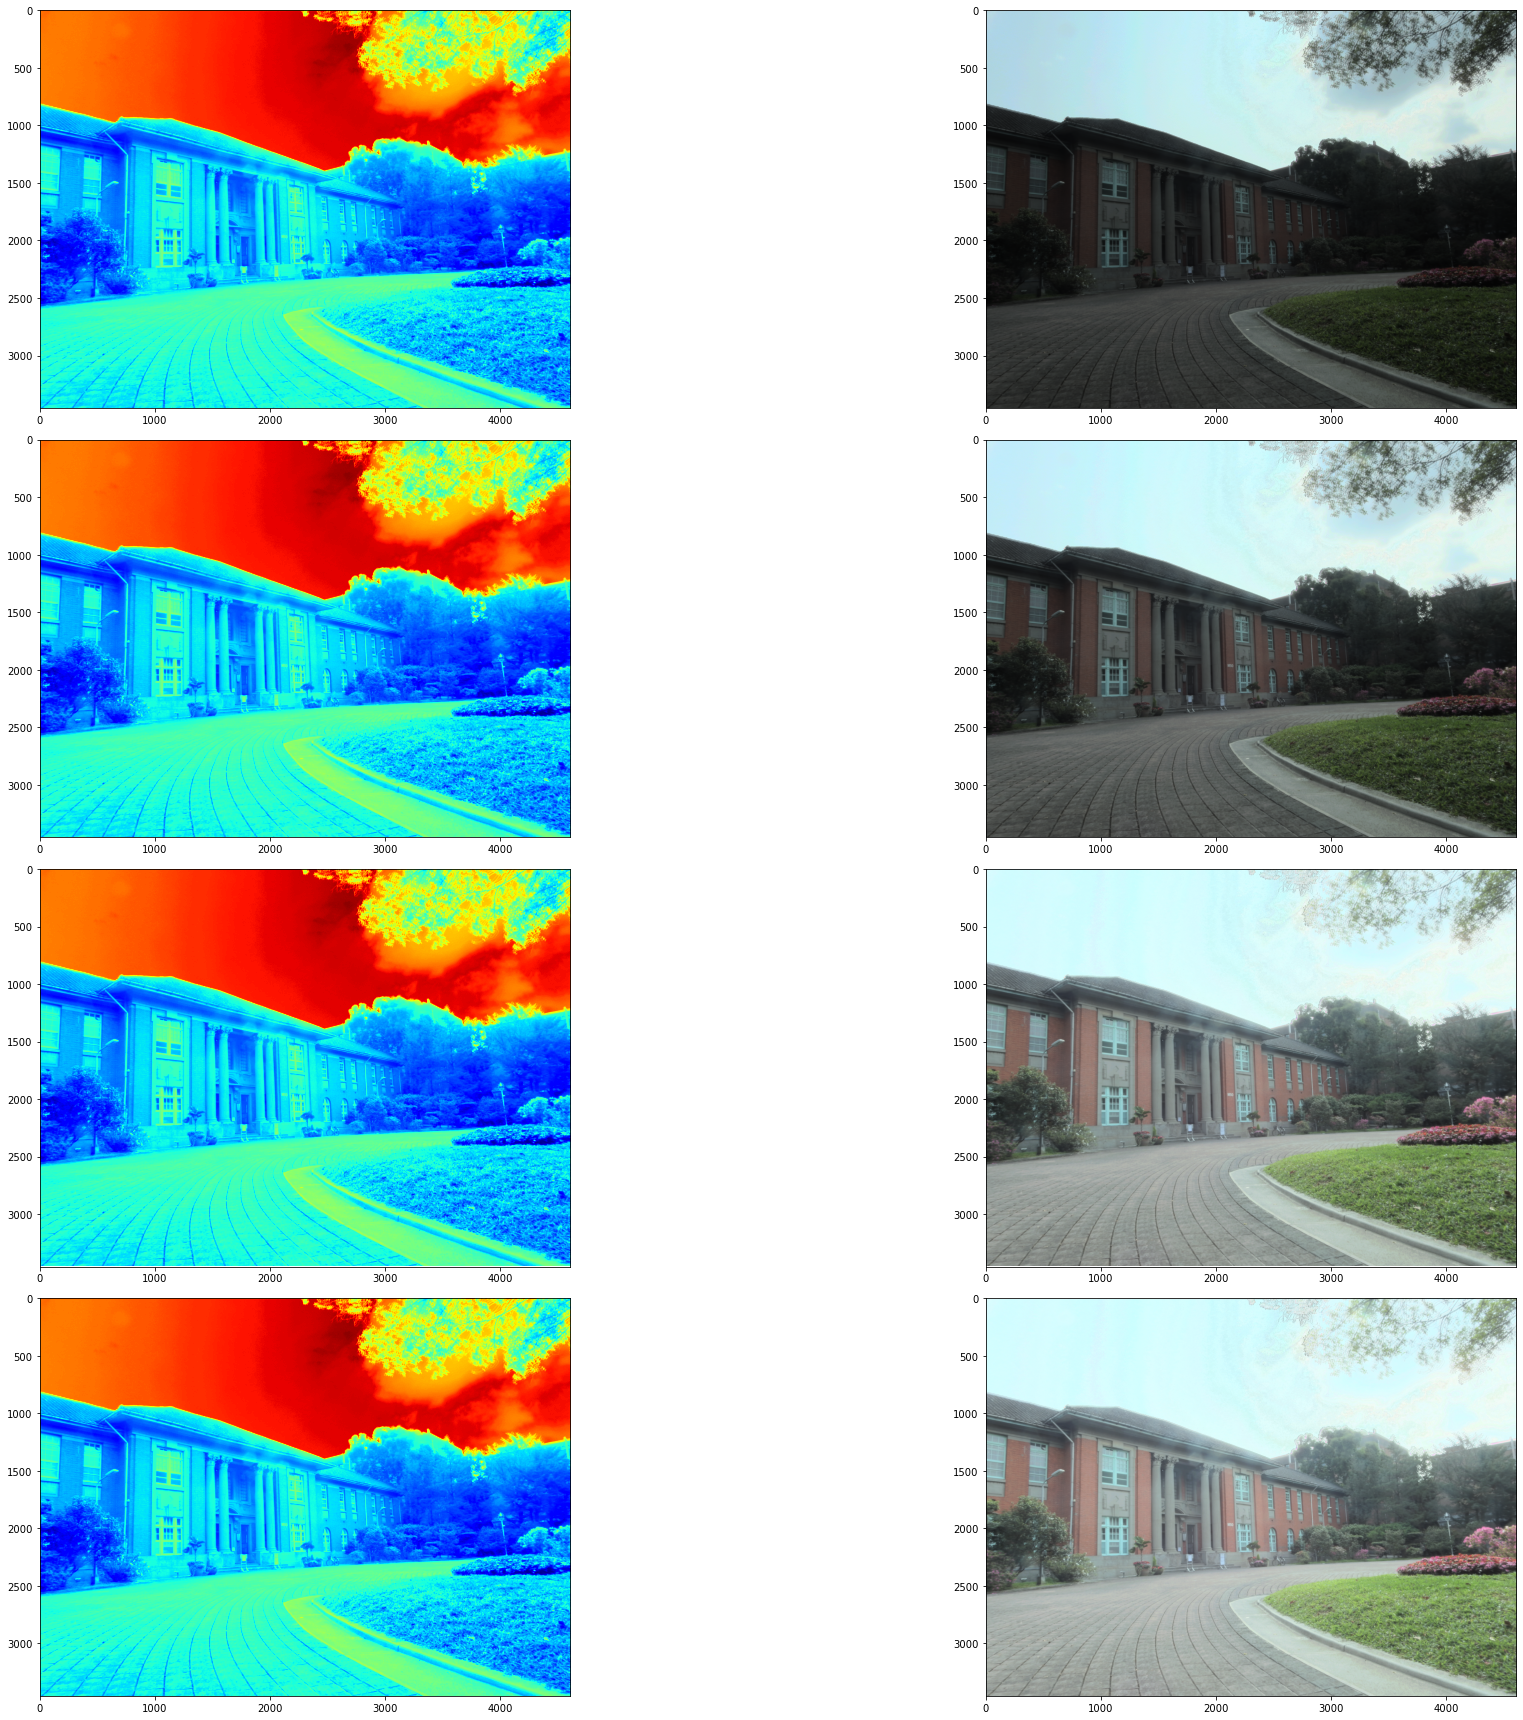

In [27]:
alphas = [0.5, 1.0, 3.0, 4.0]
fig, ax = plt.subplots(len(alphas),2,figsize=[6.4*5, 4.8*5])
for n, alpha in enumerate(alphas):
    img = tone_mapping(radiance_map, alpha=alpha)
    ax[n,0].imshow(np.log2(1e-8+2**(radiance_map[...,0])*0.299 + 2**(radiance_map[...,1])*0.587 + 2**(radiance_map[...,2])*0.114), cmap=plt.cm.jet)
    ax[n,1].imshow(img)
    cv2.imwrite('HDR2LDR-a-%.1f.png'%alpha, (img*255).astype(np.uint8)[:,:,::-1])
plt.tight_layout()
plt.show()